In [86]:
import polars as pl
from datetime import datetime
from polars import col, lit, when
from tabulate import tabulate 
pl.Config(fmt_str_lengths=50)

In [84]:

df = pl.read_ipc("data/hatecrime-ir.arrow")
df.schema

OrderedDict([('originating_agency_id', Utf8),
             ('incident_number', Utf8),
             ('incident_date', Date),
             ('data_source', Categorical),
             ('quarter', Categorical),
             ('number_of_victims', Int32),
             ('total_offenders', Int32),
             ('offenders_race', Categorical),
             ('ucr_offense_code_1', Categorical),
             ('number_of_victims_1', Int32),
             ('location_code_1', Categorical),
             ('bias_motivation_1', Categorical),
             ('types_of_victims_1', Categorical),
             ('ucr_offense_code_2', Categorical),
             ('number_of_victims_2', Int32),
             ('location_code_2', Categorical),
             ('bias_motivation_2', Categorical),
             ('types_of_victims_2', Categorical),
             ('ucr_offense_code_3', Categorical),
             ('number_of_victims_3', Int32),
             ('location_code_3', Categorical),
             ('bias_motivation_3', Categ

╒══════════════════════════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ offense_group                            │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │
╞══════════════════════════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ Destruction/Damage/Vandalism or Property │    445 │    482 │    701 │    532 │    726 │    518 │    514 │    708 │
├──────────────────────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ Intimidation                             │     97 │    106 │    164 │    215 │    244 │    254 │    182 │    296 │
├──────────────────────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ Simple Assault                           │     72 │     61 │     55 │     65 │     74 │     60 │     78 │     98 │
├──────────────────────────────────────────┼────────┼────────┼──

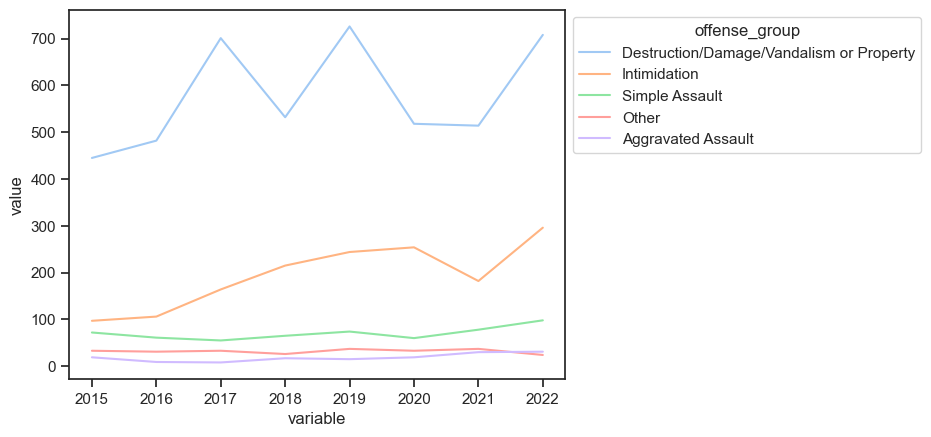

In [136]:
import seaborn as sns

enumerated_offenses = (
    "Destruction/Damage/Vandalism or Property",
    "Intimidation",
    "Simple Assault",
    "Aggravated Assault",
)

stats = df\
.filter(col("bias_motivation_1") == "Anti-Jewish")\
.with_columns(
    col("incident_date").map_elements(lambda x: datetime.strftime(x, "%Y")), 
    col("ucr_offense_code_1")
    .map_elements(lambda x: x if x in enumerated_offenses else "Other")
    .alias("offense_group")
)\
.group_by("incident_date", "offense_group")\
.count()\
.sort("incident_date", "count", descending=(False, True))\
.pivot(
    index="offense_group", 
    columns="incident_date", 
    values="count"
).fill_null(0)

table = tabulate(stats.to_dicts(), headers="keys", tablefmt="fancy_grid")
print(table)


df_plot = stats.melt(id_vars="offense_group")

sns.set_theme(style="darkgrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
ax = sns.lineplot(data=df_plot, x="variable", y="value", hue="offense_group", palette="pastel")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [45]:
offense_mapping = {
    "39B": "Operating/Promoting/Assisting Gambling",
    "39C": "Gambling Equipment Violations",
    "39D ": "Sports Tampering",
    "09A": "Murder/Non-negligent Manslaughter",
    "09B": "Negligent Manslaughter",
    "09C": "Justifiable Homicide",
    "100": "Kidnapping/Abduction",
    "23A": "Pocket-picking",
    "23B": "Purse-snatching",
    "23C": "Shoplifting",
    "23D": "Theft from Building",
    "23E": "Theft from Coin-Operated Machine or Device",
    "23F": "Theft from Motor Vehicle",
    "23G": "Theft of Motor Vehicle Parts/Accessories",
    "23H ": "All Other Larceny",
    "240": "Motor Vehicle Theft",
    "370": "Pornography/Obscene Material",
    "40A": "Prostitution",
    "40B": "Assisting or Promoting Prostitution",
    "120 ": "Robbery",
    "11A": "Rape",
    "11B": "Sodomy",
    "11C": "Sexual Assault With An Object",
    "11D": "Fondling (Indecent Liberties/Child Molestation)",
    "36A ": "Incest",
    "36B": "Statutory Rape",
    "280": "Stolen Property Offenses (Receiving, Selling, Etc.)",
    "520": "Weapon Law Violations",
}

stats = df.filter(
    col("bias_motivation_1") == "21"
).select(
    col("ucr_offense_code_1").map_dict(offense_mapping).fill_null("None").alias("offense"),
).group_by(
    "offense"
).count().sort("count", descending=True)
print(tabulate(stats.to_dicts(), tablefmt="fancy_grid", headers="keys"))

╒══════════════════════╤═════════╕
│ offense              │   count │
╞══════════════════════╪═════════╡
│ None                 │    1152 │
├──────────────────────┼─────────┤
│ Theft from Building  │       3 │
├──────────────────────┼─────────┤
│ Kidnapping/Abduction │       1 │
├──────────────────────┼─────────┤
│ Sodomy               │       1 │
╘══════════════════════╧═════════╛


In [50]:
def find_non_utf8_characters(file_path):
    with open(file_path, 'rb') as file:
        try:
            content = file.read().decode('utf-8')
        except UnicodeDecodeError as e:
            print(f"Invalid UTF-8 character found at position {e.start}: {e.reason}")
            invalid_byte = file.read(1)
            print(f"Invalid byte: {invalid_byte}")
            return

    print("No invalid UTF-8 characters found.")

file_path = 'layouts/2021-layout.yaml'
find_non_utf8_characters(file_path)

No invalid UTF-8 characters found.
